**Ghailan Fadah**

Spring 2022

CS 251: Data Analysis and Visualization

Project 7: Radial Basis Function Neural Networks

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 1: RBF Network development dataset

The eventual goal is to train a neural network so that it learns to recognize which human handwritten digit is shown in an image  (i.e. the numbers 0, 1, ..., 9). Before doing this, you will use simpler data to develop and debug your network.

### 1a. Load and preprocess data

- Load in the `rbf_dev_train.csv` and `rbf_dev_test.csv` train and test sets.
- For the train and test sets, separate the data variables (`X` and `Y`) from the class values (*class*). The test code below assumes the following names:
    - `y_train` and `y_test` for the class values in the train and test sets, respectively.
    - `rbf_dev_train` and `rbf_dev_test` for the train and test set data, respectively.
- Normalize each data feature "separately" between 0 and 1 (based on each feature's dynamic range).
    - Use the `min` and `max` values derived from the training set to normalize the test set. *This will ensure that identical feature values in the training and test sets get normalized to the same numeric value.*

**Tip:** It might be a good idea to write a few functions below so that you don't have a lot of duplicate code when processing train and test sets.

In [2]:
train =pd.read_csv('data/rbf_dev_train.csv')
test =pd.read_csv('data/rbf_dev_test.csv')

rbf_dev_train = train[['X', 'Y']].to_numpy()
rbf_dev_test = test[['X', 'Y']].to_numpy()
y_train = train[['class']].to_numpy().flatten()
y_test = test[['class']].to_numpy().flatten()

min_train = rbf_dev_train.min(axis=0)
range_train = rbf_dev_train.max(axis=0) - min_train

rbf_dev_train = (rbf_dev_train - min_train) / (range_train)
rbf_dev_test = (rbf_dev_test - min_train) / (range_train)




#### Preprocessing test code

The following test code is a good sanity check, but you are encouoraged to do additional testing to make sure that your preprocessing pipeline is working properly.

##### Check dtypes

In [3]:
print(f'Your training set is an ndarray? {isinstance(rbf_dev_train, np.ndarray)}')
print(f'Your training classes is an ndarray? {isinstance(y_train, np.ndarray)}')
print(f'Your test set is an ndarray? {isinstance(rbf_dev_test, np.ndarray)}')
print(f'Your test classes is an ndarray? {isinstance(y_test, np.ndarray)}')

Your training set is an ndarray? True
Your training classes is an ndarray? True
Your test set is an ndarray? True
Your test classes is an ndarray? True


##### Check shapes

In [4]:
print(f'Your training set shape is {rbf_dev_train.shape} and should be (1600, 2).')
print(f'Your training classes shape is {y_train.shape} and should be (1600,).')
print(f'Your test set shape is {rbf_dev_test.shape} and should be (400, 2).')
print(f'Your test classes shape is {y_test.shape} and should be (400,).')

Your training set shape is (1600, 2) and should be (1600, 2).
Your training classes shape is (1600,) and should be (1600,).
Your test set shape is (400, 2) and should be (400, 2).
Your test classes shape is (400,) and should be (400,).


### 1b. Plot data

Create a scatter plot of the training data in the cell below.

- Color code each sample by its output class.
- Make the aspect ratio (height and width) of the x and y axes in the figure equal, otherwise the plot may look distorted.

If everything is working properly, you should see a jack-o-lantern whose eyes, noise, mouth, and stem are colored differently than the rest of the face.

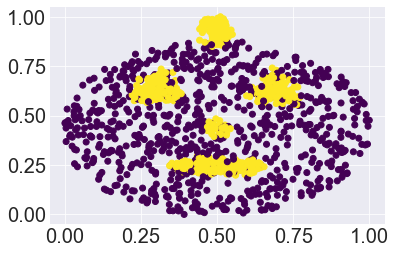

In [5]:
plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:,1], c = y_train, cmap='viridis',)

## Task 2: Radial basis function neural network

In [6]:
from rbf_net import RBF_Net

### 2a. Network initalization

You will use K-means to initialize the RBF hidden layer prototypes and sigmas.

1. Copy over your `kmeans.py` from your previous project. If your K-means clustering code isn't working properly, you may use `scipy` functions in this project instead, but at a 1 point reduction. Check out `scipy.cluster.vq.kmeans`.

2. Implement the method templates in `rbf.py` that initialize the hidden layer of the neural network:
    - Finish writing the constructor
    - `get_num_hidden_units`
    - `get_num_output_units`
    - `avg_cluster_dist`: Compute the average distance between each cluster center found by K-means and all the points assigned to the same cluster.
    - `initialize`: Use K-means to set the Gaussian hidden unit centers (**prototypes**) and standard deviations (**sigmas**).


In [7]:
from kmeans import KMeans

#### Test `avg_cluster_dist`

In [8]:
np.random.seed(0)

# N = 10 samples, M = 5 features
test_data = np.random.normal(size=(10, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_assignments = np.random.randint(low=0, high=4, size=(10,))
kmeansObj = KMeans()

test_net = RBF_Net(4, 3)
print(f'Number of hidden units in your net is {test_net.get_num_hidden_units()} and should be 4')
print(f'Number of output units in your net is {test_net.get_num_output_units()} and should be 3')
test_clust_mean_dists = test_net.avg_cluster_dist(test_data, test_centroids, test_assignments, kmeansObj)

print(f'Your avg within cluster distances are\n{test_clust_mean_dists} and should be\n[2.23811 3.94891 3.12267 3.4321]')

Number of hidden units in your net is 4 and should be 4
Number of output units in your net is 3 and should be 3
Your avg within cluster distances are
[2.23811 3.94891 3.12267 3.4321 ] and should be
[2.23811 3.94891 3.12267 3.4321]


#### Test `initialize`

In [9]:
test_net.initialize(test_data)

print(f'Your prototypes have shape {test_net.get_prototypes().shape} and the shape should be (4, 5).')
print(f'Your hidden unit sigmas have shape {test_net.sigmas.shape} and the shape should be (4,).')

Your prototypes have shape (4, 5) and the shape should be (4, 5).
Your hidden unit sigmas have shape (4,) and the shape should be (4,).


#### Test initialization methods

In the cell below, write test code for your RBF network initialization:
- Create a new RBF network with 7 hidden units and 2 output classes.
- Call the `initalize` method on it, passing in the training data.
- Create a class color-coded scatterplot of the training data with an equal axis aspect ratio, like above, now with the prototypes clearly marked with a different marker and/or color.

You should see fairly evenly distributed prototypes, with one in most, if not all, "pockets" of samples belonging to a single class.

In [10]:
# Keep me
np.random.seed(0)

# Create your network here

my_net = RBF_Net(7,2)
my_net.initialize(rbf_dev_train)



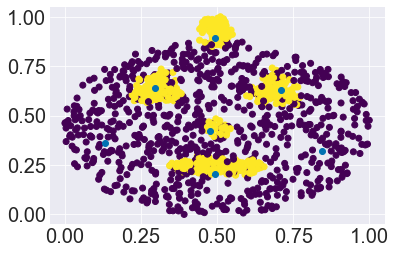

In [11]:
# Your plot here
plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:,1], c = y_train, cmap='viridis',)
plt.plot(my_net.prototypes[:, 0],my_net.prototypes[:, 1], 'o')

**Question 1:** Do you think the prototypes enable the RBF network to learn the data well? Why or why not?

**Answer 1:** Yes because they are spread over the entire dataset therefore the network has some information about the entire dataset therefore it is able to have a better prediction. If the prototypes are not spread over the entire dataset it will group classes together that are not the same leading to poor prediction

### 2b. Compute hidden and output layer activations

Implement the following methods so that you can train your RBF network:
- `hidden_act`: Computes hidden layer activation values: Determines the similarity between hidden layer prototypes with the input data.
- `output_act`: Computes output layer activation values: Multiply hidden unit activation by output unit weights.

**Hidden unit activation**:

The activation of hidden unit $j$ to data sample $i$ is computed according to $$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2\sigma_j^2 + \epsilon}\right )$$ 
where $\vec{x_i}$ is the data sample, $\vec{c_j}$ is the prototype (center) of the hidden unit, $\sigma_j$ is the hidden unit's standard deviation, $\epsilon$ is a small number (e.g. 1e-8), and $dist(\cdot, \cdot)^2$ is the **squared** Euclidean distance.

#### Test hidden_act

In [12]:
np.random.seed(1)

# N = 3 samples, M = 5 features
test_data = np.random.normal(size=(3, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_sigmas = np.random.uniform(size=(4,))
test_wts = 2*np.random.uniform(size=(4+1, 3)) - 1

test_net = RBF_Net(4, 3)
test_net.prototypes = test_centroids
test_net.sigmas = test_sigmas
test_net.wts = test_wts
test_h_act = test_net.hidden_act(test_data)
print(f'Your hidden layer activation is\n{test_h_act}\n\nand should be')
print('[[0.      0.      0.00009 0.00033]\n [0.00013 0.      0.00004 0.00014]\n [0.      0.      0.      0.00001]]')

Your hidden layer activation is
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]

and should be
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]


#### Test output_act

In [13]:
test_out_act = test_net.output_act(test_h_act)
print(f'Your output layer activation is\n{test_out_act}\n\nand should be')
print('[[-0.72136  0.61505 -0.20481]\n [-0.72151  0.61487 -0.20466]\n [-0.72144  0.61479 -0.20465]]')

Your output layer activation is
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]

and should be
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]


### 2c. Learn network weights using linear regression

To train your RBF network, you will need to find optimal weights between hidden and output layer neurons to allows your network to accurately classify the training data (i.e. learn from the data). An efficient solution is to use linear regression to solve a least square problem: minimizing the squared difference between the *hidden layer activations* and the *true data classes*.

In `rbf.py`, implement `linear_regression(A, y)`. To do this, adapt your code from the linear regression project involving `scipy.linalg.lstsq()` or `numpy.linalg.lstsq()`.

#### Test linear regression

Running the following test code should generate a familar regression fit to the Iris data.

/Volumes/Personal/gmfada24/project07/rbf_net.py:154: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(Ahat, y)[0]


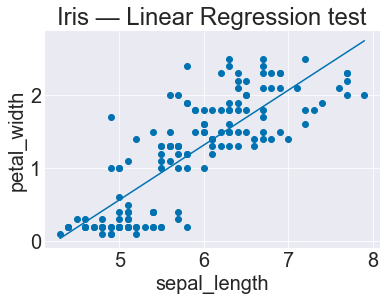

In [14]:
df = pd.read_csv('data/iris.csv')
iris = df[['sepal_length', 'petal_width']].to_numpy()

num_hidden_units = 1
num_classes = 4
net = RBF_Net(num_classes=num_classes, num_hidden_units=num_hidden_units)
iris_x = np.reshape(iris[:, 0], [len(iris), 1])
iris_y = np.reshape(iris[:, 1], [len(iris), 1])
iris_c = net.linear_regression(iris_x, iris_y)

line_x = np.linspace(iris_x.min(), iris_x.max())
line_y = line_x * iris_c[0] + iris_c[1]
plt.scatter(iris_x, iris_y)
plt.plot(line_x, line_y)
plt.title('Iris — Linear Regression test')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.show()

### 2d. Train your RBF Network

Implement the following methods then train your neural network! In the cell below, train a RBF network with 10 hidden units on the RBF dev dataset. **If everything is working, you should get >=88% accuracy on the training set and >=89% on the test set.**

- `train`: Determine the optimal output layer weights that fit hidden layer activation using linear regression.
- `predict`: Use trained network (after learning) to predict the class of data.
- `accuracy`: Compute the accuracy by comparing the network predicted and actual class for each data sample.



In [35]:
my_net2 = RBF_Net(10,2)
my_net2.train(rbf_dev_train, y_train)


/Volumes/Personal/gmfada24/project07/rbf_net.py:154: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(Ahat, y)[0]


In [36]:
# Training set accuracy
pred = my_net2.predict(rbf_dev_train)
print('Accuracy for training set: ', my_net2.accuracy(pred, y_train))

Accuracy for training set:  0.89


In [37]:
# Test set accuracy

pred = my_net2.predict(rbf_dev_test)
print('Accuracy for testing set: ', my_net2.accuracy(pred, y_test))


Accuracy for testing set:  0.9175


## Task 3: Handwritten digit classification: MNIST data

You will train a RBF network on a "real" image dataset of handwritten number digits:
- 60,000 images in training set, 10,000 images in test set.
- Each image is 28x28 pixels.
- The images are grayscale (no RGB colors).
- Each image (data sample) contains ONE of 10 numeric digit $0, 1, 2, \ldots, 8, 9$.

The goal is to train your network so that it can correctly predict the numeric digit in an image.

More information about MNIST: http://yann.lecun.com/exdb/mnist/

### 3a. Load in and look at MNIST dataset

- Use the numpy function `load` to load in the MNIST train/test data and the associated class labels.
- Create a 5x5 grid showing the first 25 images in the dataset. It should "look good" (e.g. turn off tick marks).

In [51]:
# Load data here

x_test = np.load('data/mnist_test_data.npy')
y_test = np.load('data/mnist_test_labels.npy')
x_train = np.load('data/mnist_train_data.npy')
y_train = np.load('data/mnist_train_labels.npy')

In [3]:
print(f'Your training set shape is {x_train.shape} and should be (60000, 28, 28).')
print(f'Your training classes shape is {y_train.shape} and should be (60000,).')
print(f'Your test set shape is {x_test.shape} and should be (10000, 28, 28).')
print(f'Your test classes shape is {y_test.shape} and should be (10000,).')

Your training set shape is (60000, 28, 28) and should be (60000, 28, 28).
Your training classes shape is (60000,) and should be (60000,).
Your test set shape is (10000, 28, 28) and should be (10000, 28, 28).
Your test classes shape is (10000,) and should be (10000,).


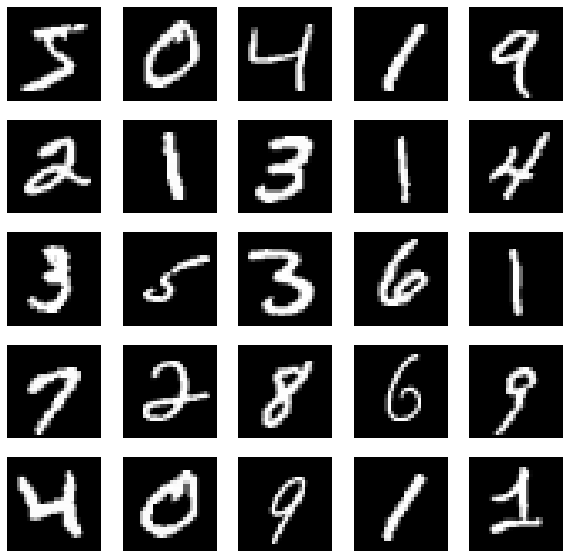

In [4]:
# 5x5 plot here

fig, ax = plt.subplots(5,5,sharex=True,sharey=True,figsize=(10,10))

y = 0
for i in range(5):
    for x in range(5):
        ax[i,x].imshow(np.squeeze(x_train[y, :, :]), cmap=plt.get_cmap('gray'))
        ax[i,x].set_xticks([])
        ax[i,x].set_yticks([])
        y+=1

### 3b. Preprocess data

- Flatten non-leading dimensions of the train and test sets. For example, the training set should go from (60000, 28, 28) to (60000, 784). **Do not hard code this!** Your code should work for any data with three dimensions.
- Normalize so that the maximum possible value in each image is 1 (and the minimum possible is 0) by dividing by 255.

In [52]:
c = x_train.shape[2] * x_train.shape[1]
x_train = np.reshape(x_train, (x_train.shape[0], c))
x_train = x_train / 255

c = x_test.shape[2] * x_test.shape[1]
x_test = np.reshape(x_test, (x_test.shape[0], c))
x_test = x_test / 255


### 3c. Train and assess performance on MNIST

Train a RBF network on MNIST. **Your goal is to get >=90% accuracy on both train and test sets.**

**Tips:**
- Depending on your laptop or machine you are using, training could take many hours if you use the full 60,000 sample training set. Select a subset to train on (e.g. ~1500) that takes a reasonable amount of time (e.g. minutes). You should be able to hit your accuracy goals without too much data, effort, or time.
- Do not pare down the test set (i.e. it should remain at 10,000 samples).
- Use the code below to visualize your hidden layer prototypes to help with debugging (assumes your network is called `mnist_net`). Your prototypes should look like images of certain digits, perhaps a little blurrier.

In [9]:
mnist_net = RBF_Net(100, 10)

mnist_net.train(x_train[:10000, :], y_train[:10000])

/Volumes/Personal/gmfada24/project07/rbf_net.py:154: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(Ahat, y)[0]


In [10]:
# train acc
pred_train = mnist_net.predict(x_train[:10000, :])
print('Accuracy for training: ', mnist_net.accuracy(y_train[:10000], pred_train))

Accuracy for training:  0.9145


In [11]:
# test acc
pred_test = mnist_net.predict(x_test[:10000, :])
print('Accuracy for testing: ', mnist_net.accuracy(y_test[:10000], pred_test))


Accuracy for testing:  0.9149


**Question 2:** Which part of the training process takes the longest?

**Answer 2:** Definitely the training part due to it having to run kmeans as well as regression

**Question 3:** What accuracy did you achieve on the training set? List all parameters that you needed to set (e.g. number of training samples, number hidden units, etc).

**Answer 3:** I was able to achieve an accuracy of 0.9145. I used 10,000 samples for trainning with 100 hidden units 

**Question 4:** Using the same parameters to get the training accuracy that you reported in Question 3, what test accuracy did you achieve?

**Answer 4:** I was able to achieve an accuracy of 0.9149

### 3d. Visualize prototypes using network weights

Now that you've trained the network to recognize handwritten digits, let's visualize the dominant factors that the network learns to rely on to make each prediction.

Create a 10 x 5 plot showing images of the 5 "most influential hidden layer prototypes" that contribute to predicting each of the 10 output classes. These are defined as the hidden layer prototypes that have the 5 largest weights going from the hidden layer to the output layer. *Recall that each hidden unit prototype has the same shape as a single data sample so each image in your grid should be 28x28.*


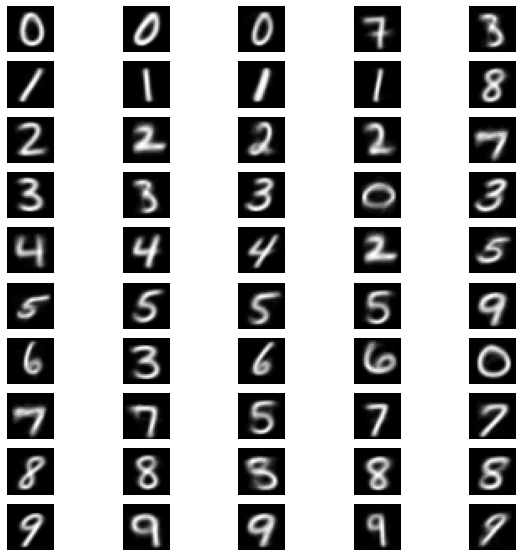

In [35]:
fig, ax = plt.subplots(10,5,sharex=True,sharey=True,figsize=(10,10))
c = 10
p = 5


for i in range(c):
    indices_pro =  np.argpartition(-mnist_net.wts[:, i], p)
    for x in range(p):
        ax[i,x].imshow(mnist_net.prototypes[indices_pro[x], :].reshape(28,28), cmap=plt.get_cmap('gray'))
        ax[i,x].set_xticks([])
        ax[i,x].set_yticks([])
    
        



**Question 5:** Interpret what each row of your 10x5 grid of images means. Did any of the top prototypes surprise you?

**Answer 5:** Each row represents each class in this case what number it is. The columns are what each top prototype predicted that number to be. For example, row 0 is for label 0 and the top 3 prototypes predicted that right while the last two predicted a wrong number. One thing that suprised me was that by the fifth top prototype it was only getting 3 out of the 10 right which is a low accuracy and this explains why increasing the number of hidden layers increases accuracy.  

## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

### 1) Improve performance on MNIST with PCA

Using all 768 features (pixels) in each image may not be very helpful for classification. For example, pixels around the border are almost always white. Transform the dataset(s) using PCA to compress the number of features before training your RBF network. Experiment with PCA to improve classification accuracy and runtime performance.

### I did task 3d and stephanie said we can claim it as an extension.

For my first extension, I decided to use something I learned in this class and connect two concepts together. Therefore, I used PCA to reduce the size of my data only keeping the top 200 most important features. This was accomplished by using the pca class I built in project 4. I first viewed the elbow plot to see how many features I need to keep in order to maintain 95 percent of the variance and that was around 200 features. Afterwards I ran pca keeping only the top 200 features and used that reduced the data to run my RBF Network on. I did this reduction for both the testing and trainning data. As seen below I was able to maintain the high accuracy >.90 while only needing 200 pixels instead of the 768 therefore this greatly improved the time performance.   

In [60]:
from pca_cov import PCA_COV

df_x_train = pd.DataFrame(x_train)
pca2 = PCA_COV(df_x_train)
pca2.pca(np.arange(0,784,1))


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


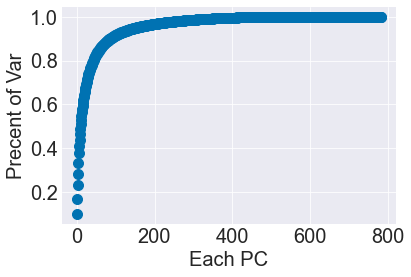

In [43]:
pca2.elbow_plot();

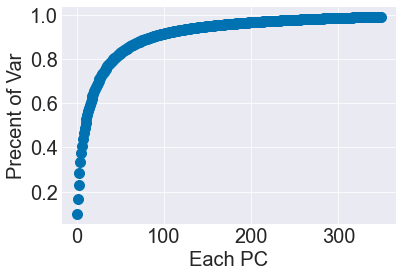

In [44]:
pca2.elbow_plot(350);

In [45]:
reduced_data = pca2.pca_project(np.arange(0,200,1))

In [46]:
reduced_data.shape

(60000, 200)

In [62]:
df_x_test = pd.DataFrame(x_test)
pca2 = PCA_COV(df_x_test)
pca2.pca(np.arange(0,784,1))
reduced_data_test = pca2.pca_project(np.arange(0,200,1))




In [64]:
mnist_net = RBF_Net(150, 10)

mnist_net.train(reduced_data[:10000, :], y_train[:10000])

pred_train = mnist_net.predict(reduced_data[:10000, :])
print('Accuracy for training: ', mnist_net.accuracy(y_train[:10000], pred_train))

pred_test = mnist_net.predict(reduced_data_test[:10000, :])
print('Accuracy for testing: ', mnist_net.accuracy(y_test[:10000], pred_test))

/Volumes/Personal/gmfada24/project07/kmeans.py:299: ComplexWarning: Casting complex values to real discards the imaginary part
  new_centers[i] = np.mean(self.data[data_centroid_labels == i], axis = 0)
/Volumes/Personal/gmfada24/project07/rbf_net.py:154: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(Ahat, y)[0]


Accuracy for training:  0.9338
Accuracy for testing:  0.0976


### 2) Visualize network predictions

Make visualizations to show and interpret the MNIST network predictions. Lots of possibilities, here are a few specific ideas:
- Make show a grid of test samples labeled with their predicted digit.
- Analyze if the network performance favors accuracy for certain digits and not others.
- Are errors on certain classes correlated in any way? Does it depend on their digit similarity (e.g. 1 looks like a 7, but not a 0).
- Make and interpret a confusion plot.

### 3) Explore parameter space

When training your RBF network on MNIST, you had to pick some parameter values to use by hand. Pick one or more parameters and systematically vary them to quantify their effect on accuracy and simulation time.

For my second extension, I wanted to see how certain parameters effect the accuracy and time of my RBF network. I first started by keeping the number of training sample constant at 10,000 and varying the number of hidden layers. As seen below when we used only 10 hidden layers we got an accuracy of around 63. When we used 50 layers we jumped to an accuray of 88. At 100 layers we got an accuray of 91 as seen above. And finally, at 150 layers we got an accuracy of 93. As we added more layers the time it took increased pretty fast and as seen above there seems to be a sweet spot where after it increasing the layers will not have a great effect on accuracy but will still effect the time it takes to run.   

In [6]:
mnist_net = RBF_Net(10, 10)

mnist_net.train(x_train[:10000, :], y_train[:10000])

pred_train = mnist_net.predict(x_train[:10000, :])
print('Accuracy for training: ', mnist_net.accuracy(y_train[:10000], pred_train))

pred_test = mnist_net.predict(x_test[:10000, :])
print('Accuracy for testing: ', mnist_net.accuracy(y_test[:10000], pred_test))

/Volumes/Personal/gmfada24/project07/rbf_net.py:154: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(Ahat, y)[0]


Accuracy for training:  0.6352
Accuracy for testing:  0.6306


In [7]:
mnist_net = RBF_Net(50, 10)

mnist_net.train(x_train[:10000, :], y_train[:10000])

pred_train = mnist_net.predict(x_train[:10000, :])
print('Accuracy for training: ', mnist_net.accuracy(y_train[:10000], pred_train))

pred_test = mnist_net.predict(x_test[:10000, :])
print('Accuracy for testing: ', mnist_net.accuracy(y_test[:10000], pred_test))

Accuracy for training:  0.8824
Accuracy for testing:  0.8779


In [8]:
mnist_net = RBF_Net(150, 10)

mnist_net.train(x_train[:10000, :], y_train[:10000])

pred_train = mnist_net.predict(x_train[:10000, :])
print('Accuracy for training: ', mnist_net.accuracy(y_train[:10000], pred_train))

pred_test = mnist_net.predict(x_test[:10000, :])
print('Accuracy for testing: ', mnist_net.accuracy(y_test[:10000], pred_test))

Accuracy for training:  0.9317
Accuracy for testing:  0.9273


Next, I varied the number of samples used for training while keeping the number of hidden layers constant at 150. As seen below for 200 samples the accuracy for training was .98 while for testing .39 and the time was very fast. For 500 samples the accuracy for the training was .96 and .82 for testing; this is a huge improvement from 200 samples and the time to run is still pretty fast at about 6 seconds. For 1000 samples the accuracy for training was .93 and .86 for testing while the time was about half a minute. For 10,000 samples as seen above the accuracy for training was .92 and .91 for testing and the time was about 10 minutes. From this we can conclude that there is also a sweet spot for the number of samples to use where after it increasing the samples will not have a great effect on accuracy but will still effect the time it takes to run. Futhermore, it was noted that the number of hidden layers are more dominant in determining the accuracy of the network.   

In [30]:
mnist_net = RBF_Net(150, 10)

mnist_net.train(x_train[:200, :], y_train[:200])

pred_train = mnist_net.predict(x_train[:200, :])
print('Accuracy for training: ', mnist_net.accuracy(y_train[:200], pred_train))

pred_test = mnist_net.predict(x_test[:200, :])
print('Accuracy for testing: ', mnist_net.accuracy(y_test[:200], pred_test))

Accuracy for training:  0.985
Accuracy for testing:  0.39


/Volumes/Personal/gmfada24/project07/rbf_net.py:154: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(Ahat, y)[0]


In [31]:
mnist_net = RBF_Net(150, 10)

mnist_net.train(x_train[:500, :], y_train[:500])

pred_train = mnist_net.predict(x_train[:500, :])
print('Accuracy for training: ', mnist_net.accuracy(y_train[:500], pred_train))

pred_test = mnist_net.predict(x_test[:500, :])
print('Accuracy for testing: ', mnist_net.accuracy(y_test[:500], pred_test))

Accuracy for training:  0.96
Accuracy for testing:  0.828


In [34]:
mnist_net = RBF_Net(150, 10)

mnist_net.train(x_train[:1000, :], y_train[:1000])

pred_train = mnist_net.predict(x_train[:1000, :])
print('Accuracy for training: ', mnist_net.accuracy(y_train[:1000], pred_train))

pred_test = mnist_net.predict(x_test[:1000, :])
print('Accuracy for testing: ', mnist_net.accuracy(y_test[:1000], pred_test))

Accuracy for training:  0.935
Accuracy for testing:  0.857


### 4) Initialization schemes

Research, test out, and quantify the performance of different techniques to set the hidden unit prototypes and sigmas. For example, an alternative way to initialize the prototypes is to perform K-means to cluster each class *separately*. 

### 5) Other datasets

Use your RBF network to classify other datasets.

### 6) SVD-based linear regression

Implement a SVD-based linear regression method, which is both fast and numerically accurate. In the equation $Ac = y$ The weights $c$ can be solved via the following matrix equation: $$c = A^+y$$ where $A^+$ is the pseudo inverse of the matrix of RBF hidden layer activations $A$ (*data matrix*) and the correct classes $y$.

Relying on numpy to figure out the pseudoinverse would be a mini extension, computing the pseudoinverse yourself would be a larger extension.

For my third extension, I decided to implemend svd based linear regression without using numpy's pseudoinverse function. When I took linear algebra this was one of the most interesting topics as I was suprised how any matrix can be broken down to its sub parts where one describes scaling one describes its transformations and the last one describes its outliers. I used numpy's svd to get those sub parts and afterwards found the pseudo inverse of s and used that along with the other two sub matrices to find the pseudoinverse of A. Afterwards I performed matrix mutiplication with A^+ and y and that gave my c which are the weights. This was all done in the method called my_linear_regression(). As seen below by running the test code given to us to test linear regression, if I use the method I created my_linear_regression() I end up with the same answer as using the linear_regression() method. 

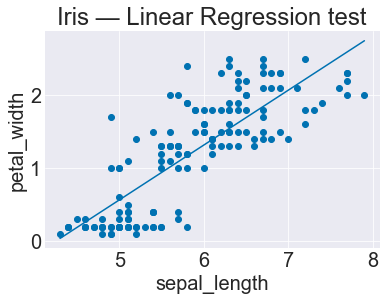

In [28]:
df = pd.read_csv('data/iris.csv')
iris = df[['sepal_length', 'petal_width']].to_numpy()

num_hidden_units = 1
num_classes = 4
net = RBF_Net(num_classes=num_classes, num_hidden_units=num_hidden_units)
iris_x = np.reshape(iris[:, 0], [len(iris), 1])
iris_y = np.reshape(iris[:, 1], [len(iris), 1])
iris_c = net.my_linear_regression(iris_x, iris_y)

line_x = np.linspace(iris_x.min(), iris_x.max())
line_y = line_x * iris_c[0] + iris_c[1]
plt.scatter(iris_x, iris_y)
plt.plot(line_x, line_y)
plt.title('Iris — Linear Regression test')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.show()

### 7) Analyze the trained network

Run simulations then analyze and interpret the results. Here are some ideas:
- Visualize and analyze how the prototypes influence the classification results.
- Visualize and analyze how the network weights influence the classification results.